In [1]:
import numpy as np

class BernoulliBandit:

    def __init__(self, K):
        self.probs = np.random.uniform(size=K)

        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K

    def step(self, k):
        return np.random.rand() < self.probs[k]

In [2]:
class Solver:

    def __init__(self, bandit: BernoulliBandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)
        self.regret = 0
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def step(self):
        raise NotImplementedError
    
    def run(self, steps):
        for _ in range(steps):
            k = self.step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

In [3]:
class EpsilonGreedy(Solver):

    def __init__(self, bandit: BernoulliBandit, epsilon=0.01, init_prob=1.0):
        super().__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K)

    def step(self):
        if np.random.rand() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

In [4]:
import matplotlib.pyplot as plt

def plot_results(solvers: Solver, solver_names: list[str]):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])

    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title(f'{solvers[0].bandit.K}-armed bandit')
    plt.legend()
    plt.show()

Accumulated regrets: 739.1768805841766


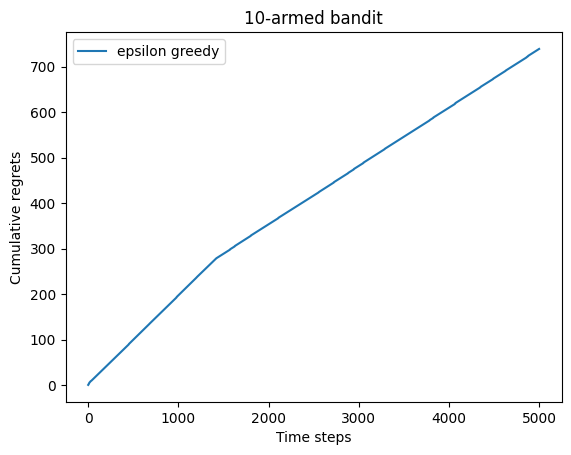

In [5]:
np.random.seed(43)

K = 10

bandit_10 = BernoulliBandit(K)

epsilon_solver = EpsilonGreedy(bandit_10, epsilon=0.01)
epsilon_solver.run(5000)
print(f'Accumulated regrets: {epsilon_solver.regret}')
plot_results([epsilon_solver], ['epsilon greedy'])

In [6]:
class DecayingEpsilonGreedy(Solver):

    def __init__(self, bandit: BernoulliBandit, init_prob=1.0):
        super().__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def step(self):
        self.total_count += 1
        if np.random.rand() < 1 / self.total_count:
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

Accumulated regrets: 6.528610757542595


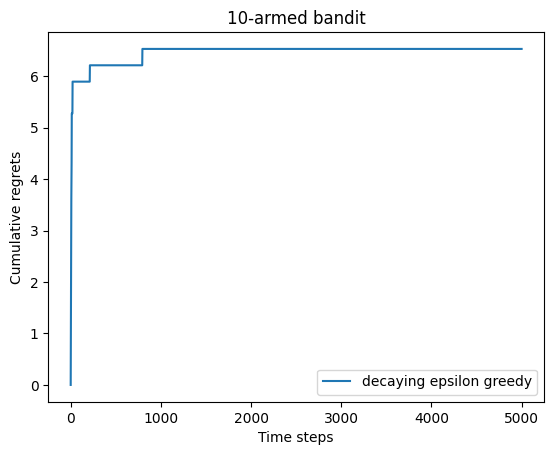

In [7]:
decaying_epsilon_solver = DecayingEpsilonGreedy(bandit_10)
decaying_epsilon_solver.run(5000)
print(f'Accumulated regrets: {decaying_epsilon_solver.regret}')
plot_results([decaying_epsilon_solver], ['decaying epsilon greedy'])

In [8]:
class UCB(Solver):

    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) /
                                                   (2 * (self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

        

Accumulated regrets: 80.48090571489506


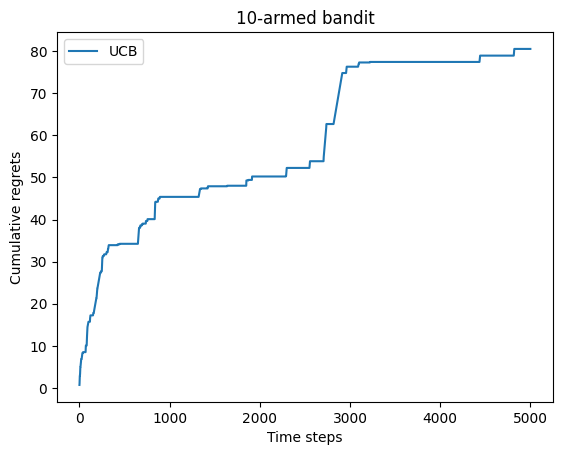

In [9]:
np.random.seed(43)

K = 10

bandit_10 = BernoulliBandit(K)

ucb_solver = UCB(bandit_10, coef=1)
ucb_solver.run(5000)
print(f'Accumulated regrets: {ucb_solver.regret}')
plot_results([ucb_solver], ['UCB'])

In [10]:
class ThompsonSampling(Solver):

    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)
        self._b = np.ones(self.bandit.K)

    def step(self):
        samples = np.random.beta(self._a, self._b)
        k = np.argmax(samples)
        r = self.bandit.step(k)

        self._a[k] += r
        self._b[k] += (1 - r)

        return k

Accumulated regrets: <__main__.ThompsonSampling object at 0x0000024815FA6C60>


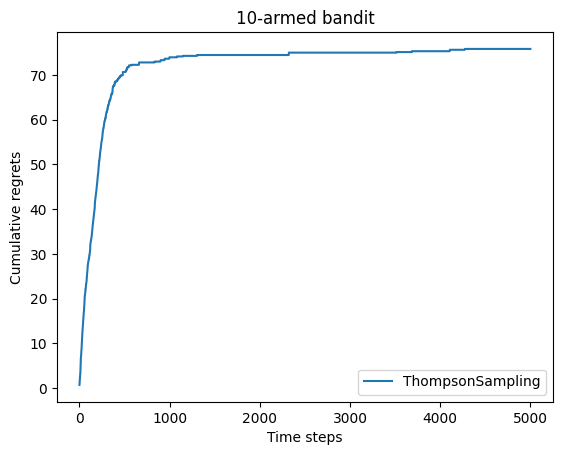

In [12]:
np.random.seed(43)

K = 10

bandit_10 = BernoulliBandit(K)

thompson_sampling_solver = ThompsonSampling(bandit_10)
thompson_sampling_solver.run(5000)
print(f'Accumulated regrets: {thompson_sampling_solver}')
plot_results([thompson_sampling_solver], ['ThompsonSampling'])